# 1. Extracción de datos

Descarga de los tres datasets necesarios para el análisis desde MinIO:
- **Scheduled** (`df_s`): paso a paso de cada tren planificado con su retraso real.
- **Eventos** (`df_e`): eventos del día (deportes, conciertos, actos públicos) con sus paradas de metro afectadas.
- **Unscheduled** (`df_u`): trenes extra no planificados desplegados por la MTA fuera del horario habitual.

## 1.1 Datos scheduled y eventos

In [93]:
import os
import sys
import pandas as pd

ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ruta_raiz not in sys.path:
    sys.path.insert(0, ruta_raiz)

from src.common.minio_client import download_df_parquet

access_key = os.getenv("MINIO_ACCESS_KEY")
if access_key is None:
    raise AssertionError("MINIO_ACCESS_KEY no definida.")

secret_key = os.getenv("MINIO_SECRET_KEY")
if secret_key is None:
    raise AssertionError("MINIO_SECRET_KEY no definida.")

# ── Rango de fechas ───────────────────────────────────────────────────────────
fecha_inicio = "2025-01-01"
fecha_fin    = "2025-01-07"
fechas = pd.date_range(fecha_inicio, fecha_fin).strftime("%Y-%m-%d").tolist()

dfs_s, dfs_e = [], []

for fecha in fechas:
    try:
        s = download_df_parquet(
            access_key=access_key,
            secret_key=secret_key,
            object_name=f"grupo5/cleaned/gtfs_clean_scheduled/date={fecha}/gtfs_scheduled_{fecha}.parquet",
        )
        s["service_date"] = fecha
        dfs_s.append(s)
    except Exception as e:
        print(f"  [scheduled] Sin datos para {fecha}: {e}")

    try:
        e = download_df_parquet(
            access_key=access_key,
            secret_key=secret_key,
            object_name=f"grupo5/cleaned/eventos_nyc/date={fecha}/eventos_{fecha}.parquet",
        )
        dfs_e.append(e)
    except Exception as e:
        print(f"  [eventos]   Sin datos para {fecha}: {e}")

df_s = pd.concat(dfs_s, ignore_index=True)
df_e = pd.concat(dfs_e, ignore_index=True)

print(f"¡Descarga exitosa! {len(fechas)} días")
print(f"  df_s: {len(df_s):,} filas | df_e: {len(df_e):,} filas")


  [eventos]   Sin datos para 2025-01-04: S3 operation failed; code: NoSuchKey, message: The specified key does not exist., resource: /pd1/grupo5/cleaned/eventos_nyc/date=2025-01-04/eventos_2025-01-04.parquet, request_id: 1898B84A035EDD0E, host_id: 3299617a0d4631a2795cf20e2489e9c27d78d0443dc7b8a9b90edbf25d1b6b72, bucket_name: pd1, object_name: grupo5/cleaned/eventos_nyc/date=2025-01-04/eventos_2025-01-04.parquet
  [eventos]   Sin datos para 2025-01-05: S3 operation failed; code: NoSuchKey, message: The specified key does not exist., resource: /pd1/grupo5/cleaned/eventos_nyc/date=2025-01-05/eventos_2025-01-05.parquet, request_id: 1898B84A38A45467, host_id: 3299617a0d4631a2795cf20e2489e9c27d78d0443dc7b8a9b90edbf25d1b6b72, bucket_name: pd1, object_name: grupo5/cleaned/eventos_nyc/date=2025-01-05/eventos_2025-01-05.parquet
¡Descarga exitosa! 7 días
  df_s: 1,046,665 filas | df_e: 78 filas


## 1.2 Datos unscheduled

In [94]:
import pandas as pd

base_uns = "grupo5/cleaned/gtfs_clean_unscheduled"
filename_patterns = [
    "gtfs_unscheduled_{date}.parquet",
    "gtfs_clean_unscheduled_{date}.parquet",
    "gtfs_cleaned_unscheduled_{date}.parquet",
    "unscheduled_{date}.parquet",
]

def descargar_uns(fecha):
    for patt in filename_patterns:
        nombre = patt.format(date=fecha)
        path   = f"{base_uns}/date={fecha}/{nombre}"
        try:
            tmp = download_df_parquet(
                access_key=access_key,
                secret_key=secret_key,
                object_name=path,
            )
            tmp["service_date"] = pd.to_datetime(fecha)
            return tmp
        except Exception:
            continue
    return None

dfs_u = [descargar_uns(f) for f in fechas]
dfs_u = [d for d in dfs_u if d is not None]

if not dfs_u:
    raise ValueError("No se encontró ningún parquet unscheduled.")

df_u = pd.concat(dfs_u, ignore_index=True)

if "td_real" not in df_u.columns:
    if "actual_seconds" in df_u.columns:
        df_u["td_real"] = pd.to_timedelta(df_u["actual_seconds"], unit="s", errors="coerce")
    else:
        raise ValueError("El dataset unscheduled no tiene 'td_real' ni 'actual_seconds'.")

df_u.dropna(subset=["td_real"], inplace=True)
df_u["td_real"] = pd.to_timedelta(df_u["td_real"])

if "trip_uid" not in df_u.columns:
    raise ValueError("El dataset unscheduled no tiene 'trip_uid'.")

print(f"¡Descarga exitosa! df_u: {len(df_u):,} filas de {df_u['service_date'].nunique()} días")


¡Descarga exitosa! df_u: 343,807 filas de 7 días


# 2. Transformaciones

Preparación de los datos antes del análisis:
- Normalización del formato de horas en `df_e` para poder operar con ventanas temporales.
- Eliminación de columnas irrelevantes en `df_s` y creación de `td_real` como `Timedelta` para comparar horas directamente.

## 2.1 Formato de horas en df_e

In [95]:
import pandas as pd


df_e["hora_inicio"] = pd.to_datetime(
    df_e["hora_inicio"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')

df_e["hora_salida_estimada"] = pd.to_datetime(
    df_e["hora_salida_estimada"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')




## 2.2 Limpieza de df_s y cálculo de td_real

In [96]:

columnas_basura = [
    'scheduled_time',   
    'actual_time',     
    'is_unscheduled',   
    'hour_sin',         
    'hour_cos',        
    'dow',                   
]


df_s['hora_real_hhmm'] = pd.to_datetime(df_s['actual_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s['hora_programada_hhmm'] = pd.to_datetime(df_s['scheduled_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s.drop(columns=columnas_basura, inplace=True, errors='ignore')



# 3. Análisis y Gráficas

Análisis del impacto de los eventos sobre el servicio de metro de NYC.  
Se abordan tres dimensiones: **retrasos en trenes programados** (scheduled), **distribución temporal del retraso** en fases alrededor del evento, y **actividad de trenes extra** (unscheduled) como señal de refuerzo del servicio.

## 3.1 Impacto neto en retrasos (entrada / salida)

Compara el retraso promedio en la **parada del evento** frente al **resto de la red (ciudad)** en dos ventanas de 1 hora:
- **Entrada**: la hora previa al inicio del evento (llegada de asistentes).
- **Salida**: la hora posterior al fin del evento (dispersión de asistentes).



El **impacto neto** es la diferencia entre ambos (parada − ciudad). Valores positivos indican que la parada sufre más retraso que la media; negativos que va mejor que la ciudad en ese momento.

In [97]:
import pandas as pd

df_s['td_real'] = pd.to_timedelta(df_s['hora_real_hhmm'], errors='coerce')
df_s = df_s.dropna(subset=['td_real'])

resumen_eventos = []

for index, evento in df_e.iterrows():
    nombre     = evento['nombre_evento']
    parada     = evento['stop_id']
    fecha      = evento['fecha_inicio']

    # Filtrar trenes del mismo día que el evento
    df_dia = df_s[df_s['service_date'] == fecha]

    hora_inicio_math = pd.to_timedelta(evento['hora_inicio'])
    inicio_entrada   = hora_inicio_math - pd.Timedelta(hours=1)

    trenes_entrada = df_dia[(df_dia['td_real'] >= inicio_entrada) & (df_dia['td_real'] <= hora_inicio_math)]
    retraso_entrada_evento = trenes_entrada[trenes_entrada['stop_id'] == parada]['delay_minutes'].mean()
    retraso_entrada_resto  = trenes_entrada[trenes_entrada['stop_id'] != parada]['delay_minutes'].mean()

    hora_salida_math = pd.to_timedelta(evento['hora_salida_estimada'])

    trenes_salida = df_dia[(df_dia['td_real'] >= hora_salida_math) & (df_dia['td_real'] <= hora_salida_math + pd.Timedelta(hours=1))]
    retraso_salida_evento = trenes_salida[trenes_salida['stop_id'] == parada]['delay_minutes'].mean()
    retraso_salida_resto  = trenes_salida[trenes_salida['stop_id'] != parada]['delay_minutes'].mean()

    resumen_eventos.append({
        'Fecha':  fecha,
        'Evento': nombre,
        'Parada': parada,
        'Retraso Ciudad Entrada (Mins)': round(retraso_entrada_resto,  2) if pd.notna(retraso_entrada_resto)  else 0,
        'Retraso Parada Entrada (Mins)': round(retraso_entrada_evento, 2) if pd.notna(retraso_entrada_evento) else 0,
        'Impacto NETO Entrada (Mins)':   round(retraso_entrada_evento - retraso_entrada_resto, 2) if pd.notna(retraso_entrada_evento) and pd.notna(retraso_entrada_resto) else 0,
        'Retraso Ciudad Salida (Mins)':  round(retraso_salida_resto,   2) if pd.notna(retraso_salida_resto)   else 0,
        'Retraso Parada Salida (Mins)':  round(retraso_salida_evento,  2) if pd.notna(retraso_salida_evento)  else 0,
        'Impacto NETO Salida (Mins)':    round(retraso_salida_evento  - retraso_salida_resto,  2) if pd.notna(retraso_salida_evento)  and pd.notna(retraso_salida_resto)  else 0,
    })

df_impacto = pd.DataFrame(resumen_eventos).sort_values(by=['Fecha', 'Impacto NETO Salida (Mins)'], ascending=[True, False])
df_impacto.reset_index(drop=True, inplace=True)
df_impacto


,Fecha,Evento,Parada,Retraso Ciudad Entrada (Mins),Retraso Parada Entrada (Mins),Impacto NETO Entrada (Mins),Retraso Ciudad Salida (Mins),Retraso Parada Salida (Mins),Impacto NETO Salida (Mins)
0,2025-01-01,chanuka event,241S,0.76,3.08,2.32,0.59,3.62,3.03
1,2025-01-01,Utah Jazz at New York Knicks,R17N,0.59,2.69,2.10,1.19,4.07,2.88
2,2025-01-01,chanuka event,248S,0.76,3.02,2.26,0.59,1.52,0.92
3,2025-01-01,Utah Jazz at New York Knicks,633S,0.60,-0.18,-0.77,1.20,1.49,0.29
4,2025-01-01,chanuka event,A46N,0.76,1.16,0.40,0.60,0.87,0.27
...,...,...,...,...,...,...,...,...,...
73,2025-01-07,Dallas Stars at New York Rangers,D17N,1.20,-0.13,-1.33,2.62,0.03,-2.59
74,2025-01-07,Dallas Stars at New York Rangers,R17N,1.19,0.35,-0.85,2.62,-0.65,-3.27
75,2025-01-07,Dallas Stars at New York Rangers,633N,1.19,2.16,0.97,2.62,-0.90,-3.52
76,2025-01-07,Dallas Stars at New York Rangers,R18N,1.19,-1.56,-2.75,2.62,-1.41,-4.03


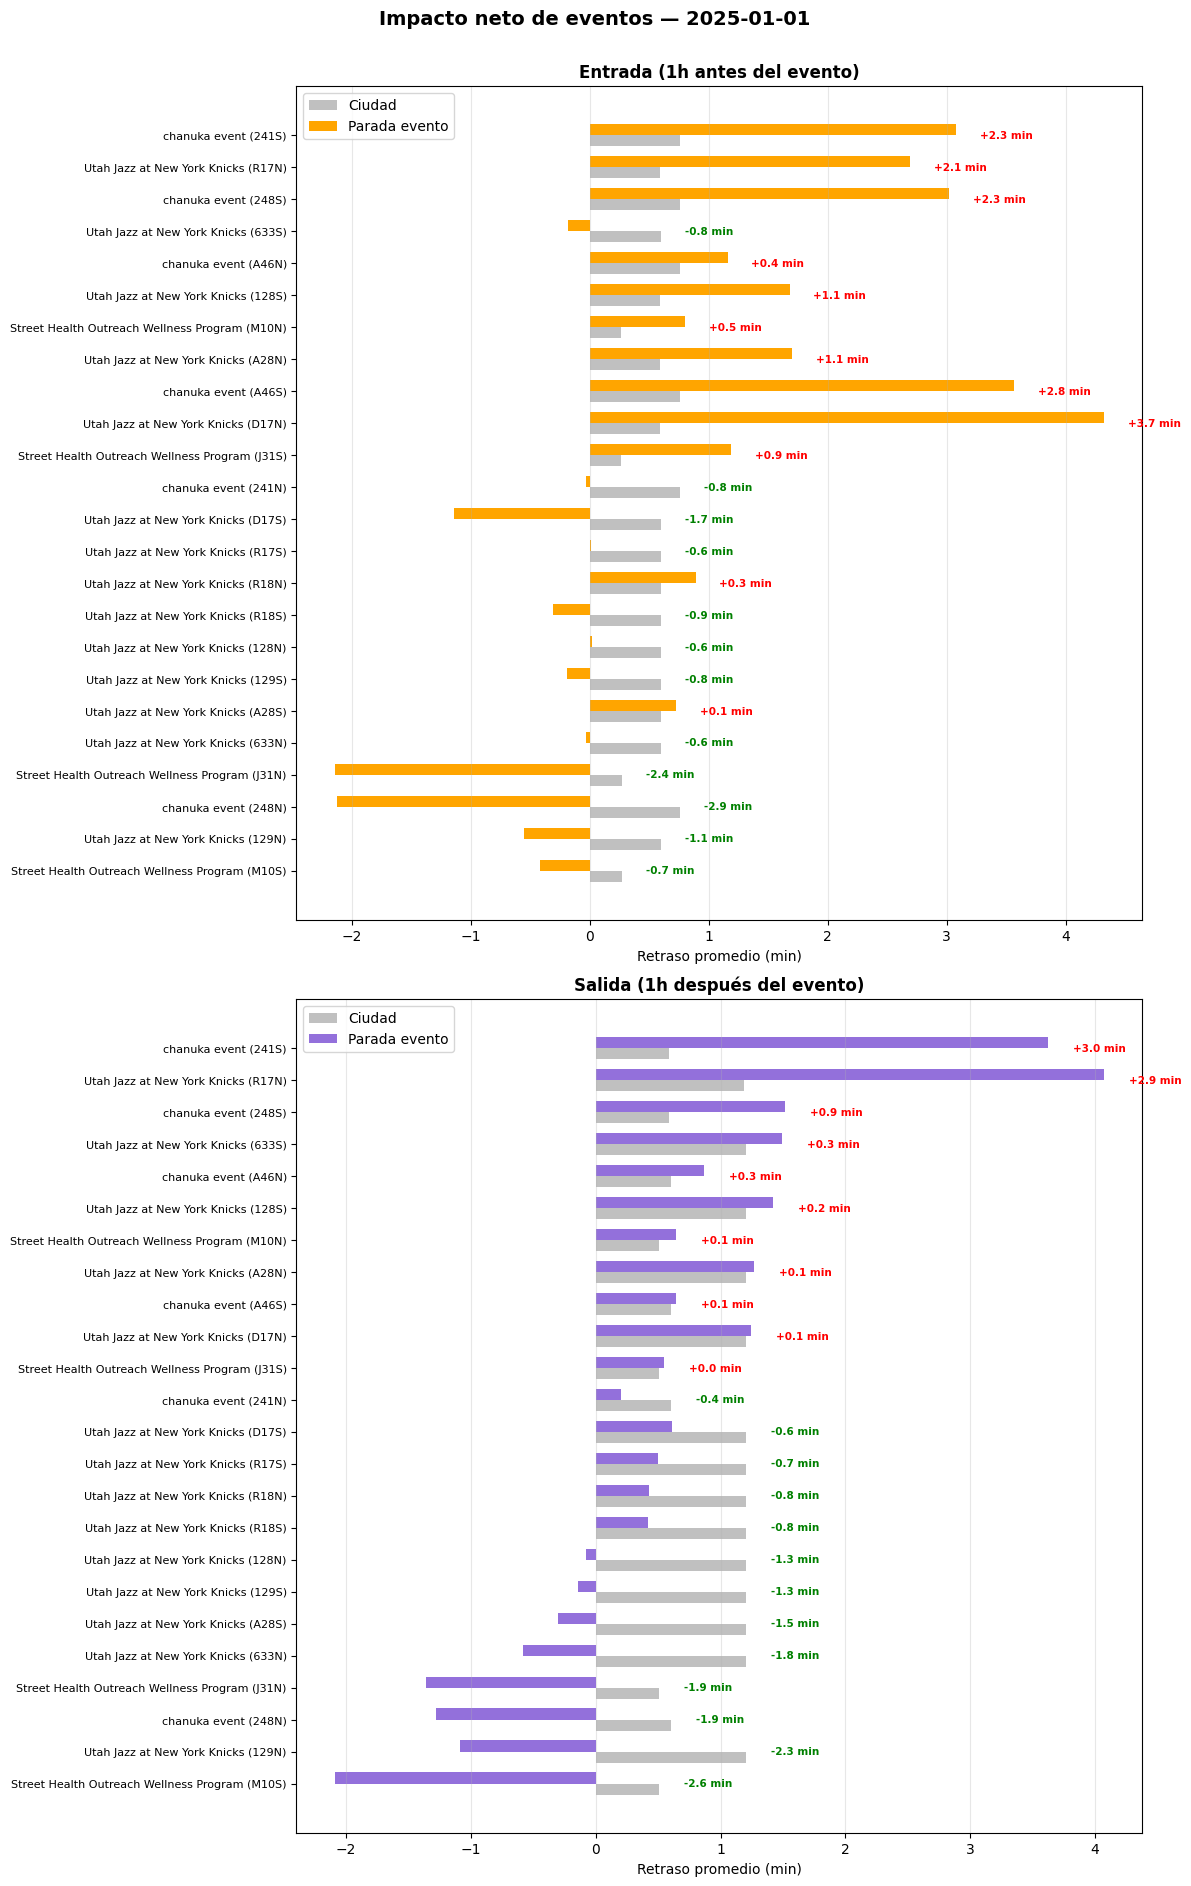

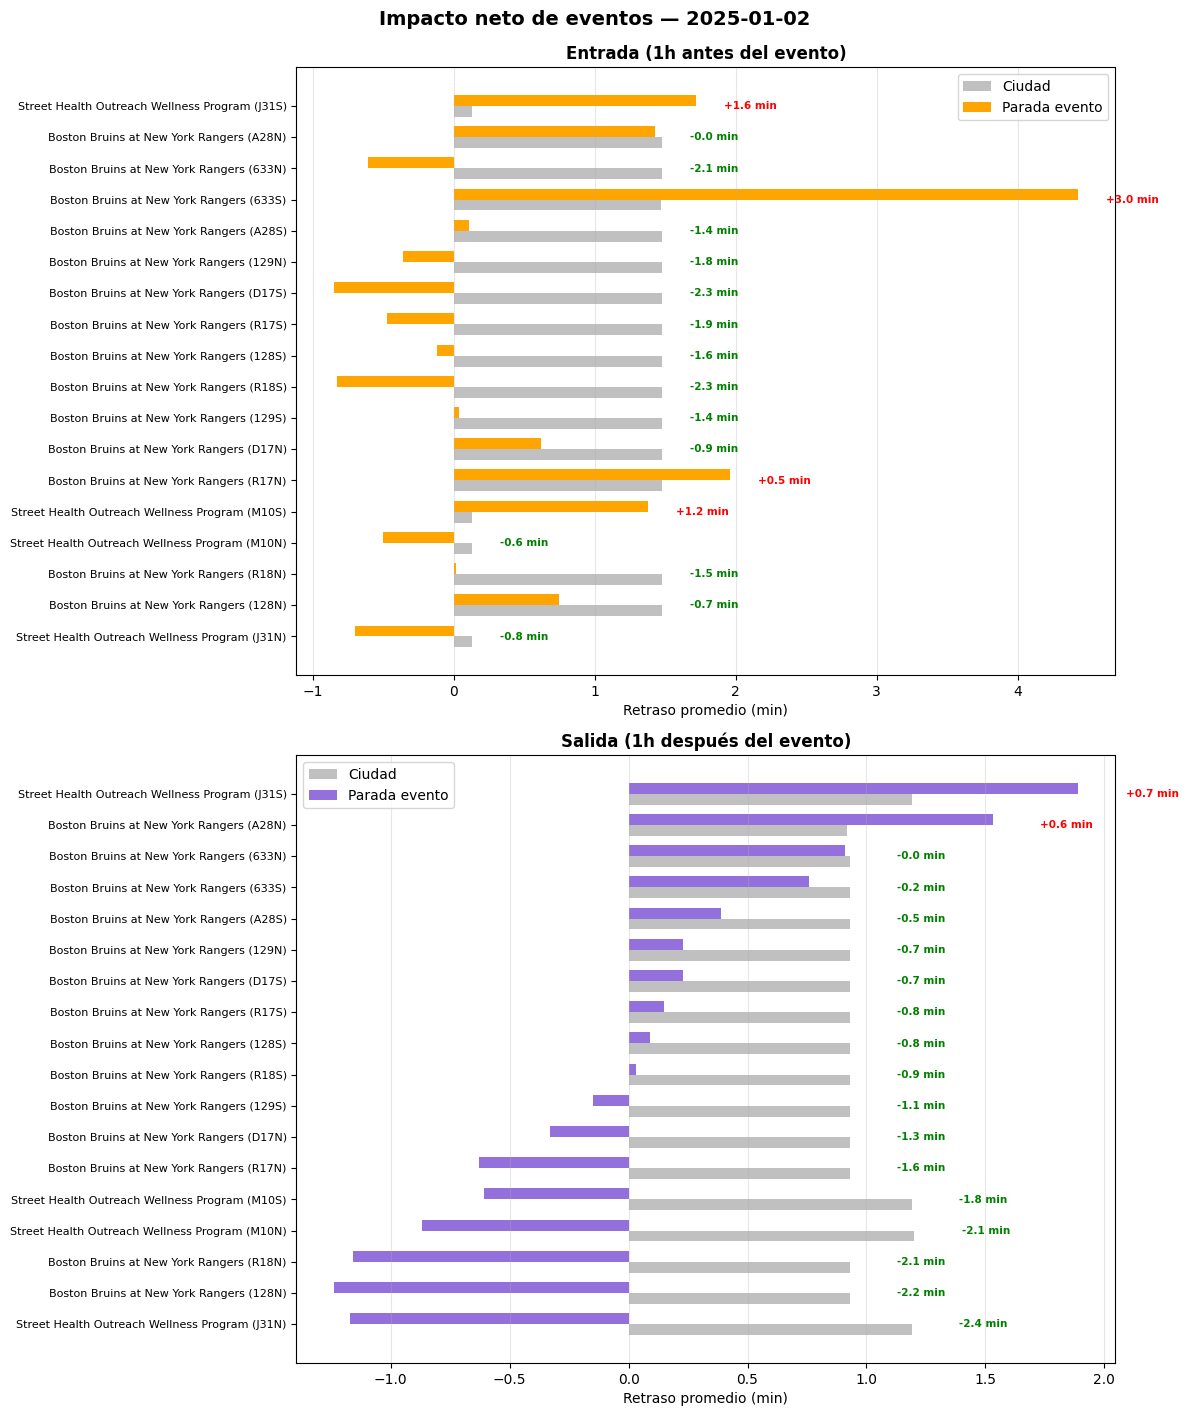

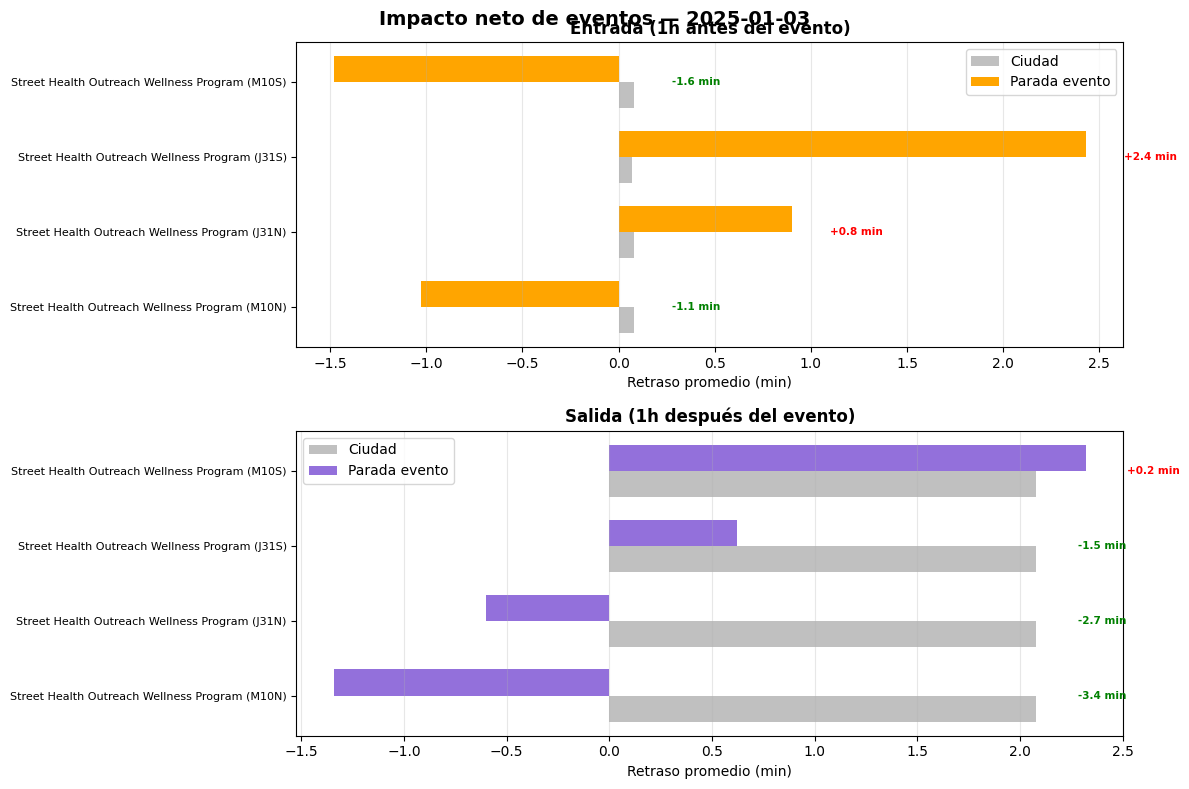

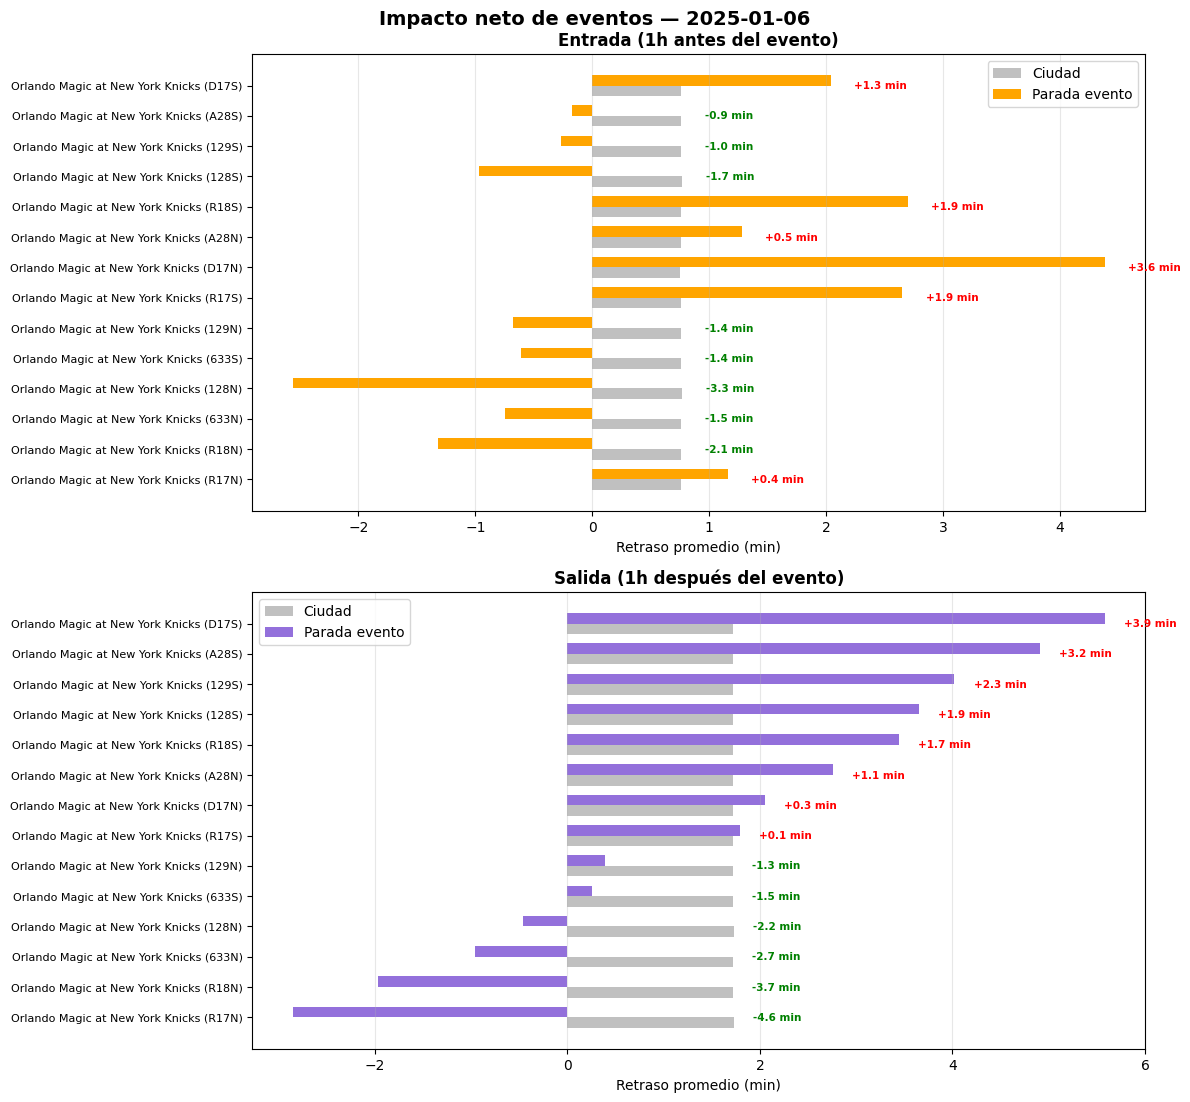

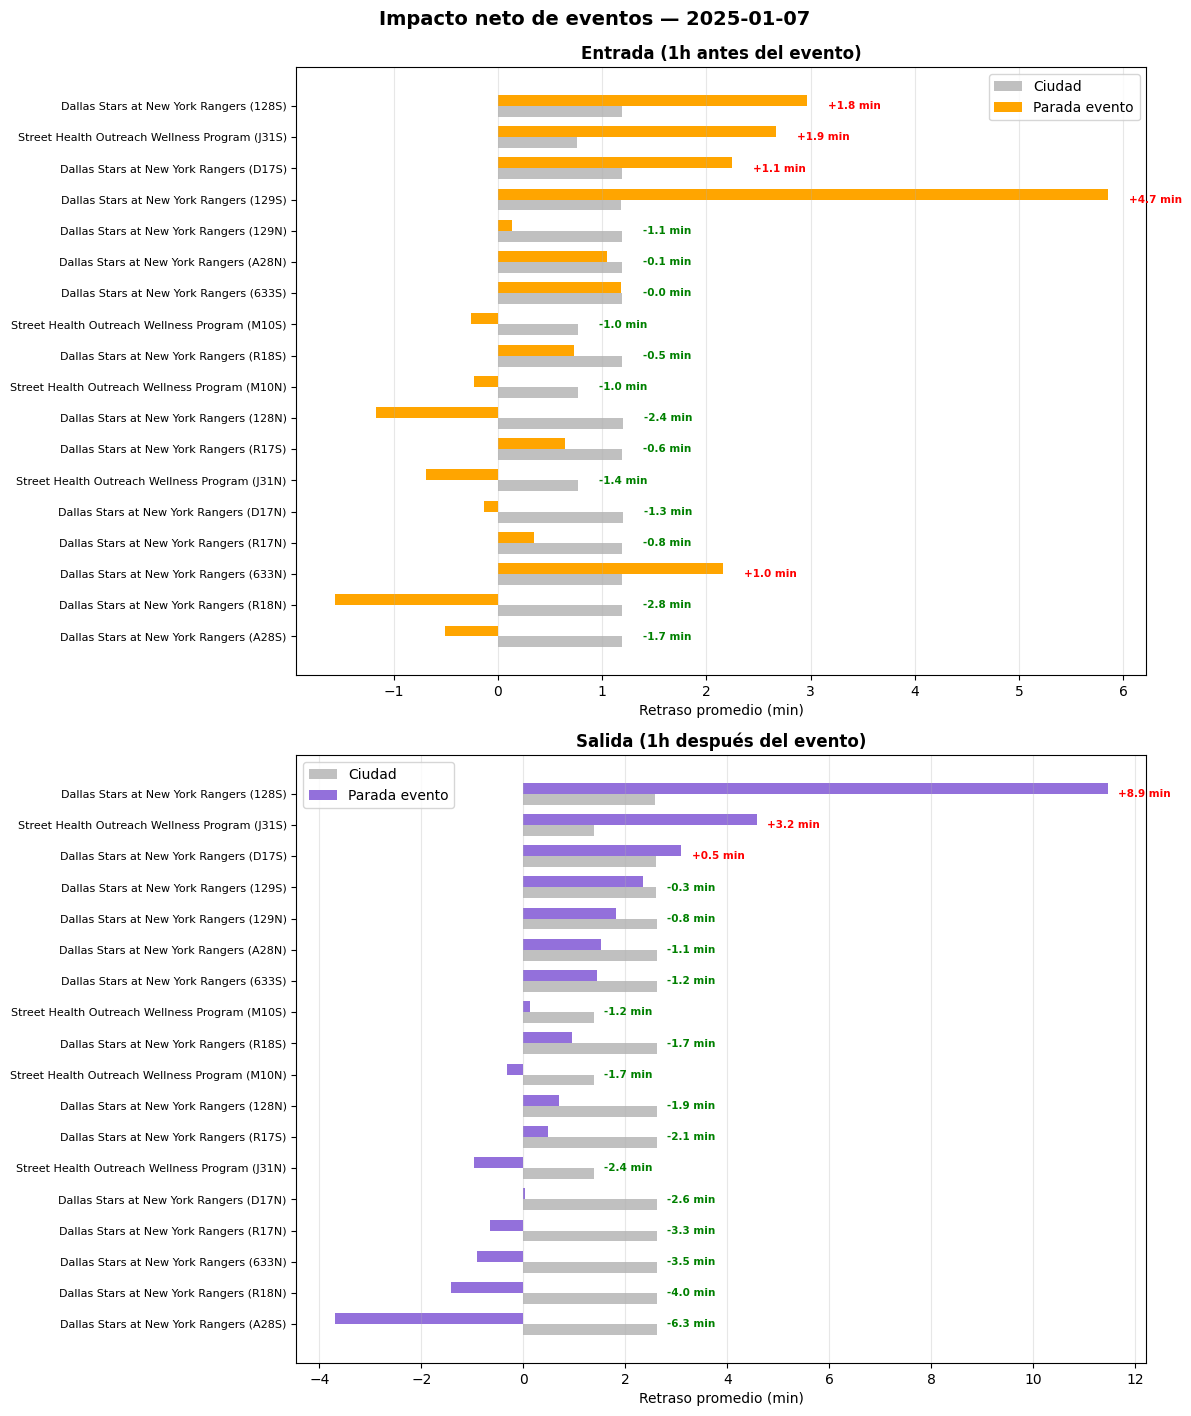

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

for fecha, df_dia_plot in df_impacto.groupby('Fecha'):
    df_dia_plot = df_dia_plot.reset_index(drop=True)
    etiquetas = df_dia_plot['Evento'] + ' (' + df_dia_plot['Parada'].astype(str) + ')'
    y    = np.arange(len(etiquetas))
    alto = 0.35

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, max(8, len(etiquetas) * 0.8)))

    ax1.barh(y + alto/2, df_dia_plot['Retraso Ciudad Entrada (Mins)'], alto, label='Ciudad',       color='silver')
    ax1.barh(y - alto/2, df_dia_plot['Retraso Parada Entrada (Mins)'], alto, label='Parada evento', color='orange')
    for i, val in enumerate(df_dia_plot['Impacto NETO Entrada (Mins)']):
        xpos  = max(df_dia_plot['Retraso Parada Entrada (Mins)'].iloc[i], df_dia_plot['Retraso Ciudad Entrada (Mins)'].iloc[i]) + 0.2
        color = 'red' if val > 0 else 'green'
        ax1.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color)
    ax1.set_title('Entrada (1h antes del evento)', fontweight='bold')
    ax1.set_yticks(y); ax1.set_yticklabels(etiquetas, fontsize=8)
    ax1.set_xlabel('Retraso promedio (min)'); ax1.legend(); ax1.grid(axis='x', alpha=0.3); ax1.invert_yaxis()

    ax2.barh(y + alto/2, df_dia_plot['Retraso Ciudad Salida (Mins)'], alto, label='Ciudad',       color='silver')
    ax2.barh(y - alto/2, df_dia_plot['Retraso Parada Salida (Mins)'], alto, label='Parada evento', color='mediumpurple')
    for i, val in enumerate(df_dia_plot['Impacto NETO Salida (Mins)']):
        xpos  = max(df_dia_plot['Retraso Parada Salida (Mins)'].iloc[i], df_dia_plot['Retraso Ciudad Salida (Mins)'].iloc[i]) + 0.2
        color = 'red' if val > 0 else 'green'
        ax2.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color)
    ax2.set_title('Salida (1h después del evento)', fontweight='bold')
    ax2.set_yticks(y); ax2.set_yticklabels(etiquetas, fontsize=8)
    ax2.set_xlabel('Retraso promedio (min)'); ax2.legend(); ax2.grid(axis='x', alpha=0.3); ax2.invert_yaxis()

    fig.suptitle(f'Impacto neto de eventos — {fecha}', fontsize=14, fontweight='bold')
    fig.tight_layout(); fig.subplots_adjust(top=0.94)
    plt.show()


## 3.2 Análisis por fases (5 fases)

Evolución del retraso medio en la parada del evento a lo largo de **5 fases temporales** con ventana de 1.5 horas cada una:

| Fase | Ventana |
|------|---------|
| Antes | de −6h a −3h antes del inicio |
| Entrada | de −1.5h a inicio |
| Durante | del inicio al fin del evento |
| Salida | del fin a +1.5h |
| Después | de +1.5h en adelante (acotado al último tren disponible) |

El heatmap permite detectar en qué fase y en qué paradas se concentra el mayor retraso.

In [99]:
resumen_final = []

ventana = pd.Timedelta(hours=1.5)
fin_dia = pd.Timedelta(hours=23, minutes=59)

for index, fila in df_e.iterrows():
    evento_nombre = fila['nombre_evento']
    stop          = fila['stop_id']
    fecha         = fila['fecha_inicio']
    hora_inicio   = pd.to_timedelta(fila['hora_inicio'])
    hora_salida   = pd.to_timedelta(fila['hora_salida_estimada'])

    df_dia    = df_s[df_s['service_date'] == fecha]
    df_parada = df_dia[df_dia['stop_id'] == stop]

    antes   = df_parada[(df_parada['td_real'] >= hora_inicio - ventana*4) & (df_parada['td_real'] < hora_inicio - ventana)]
    entrada = df_parada[(df_parada['td_real'] >= hora_inicio - ventana)   & (df_parada['td_real'] < hora_inicio)]
    durante = df_parada[(df_parada['td_real'] >= hora_inicio)             & (df_parada['td_real'] <= hora_salida)]
    salida  = df_parada[(df_parada['td_real'] >  hora_salida)             & (df_parada['td_real'] <= hora_salida + ventana)]

    ultimo_tren    = df_parada['td_real'].dropna().max()
    inicio_despues = hora_salida + ventana
    if pd.isna(ultimo_tren) or inicio_despues > fin_dia:
        despues = df_parada[(df_parada['td_real'] > hora_salida) & (df_parada['td_real'] <= fin_dia)]
    else:
        despues = df_parada[(df_parada['td_real'] > inicio_despues)]

    resumen_final.append({
        'Fecha':   fecha,
        'Evento':  evento_nombre,
        'Parada':  stop,
        'Antes':   round(antes['delay_minutes'].mean(),   2),
        'Entrada': round(entrada['delay_minutes'].mean(), 2),
        'Durante': round(durante['delay_minutes'].mean(), 2),
        'Salida':  round(salida['delay_minutes'].mean(),  2),
        'Después': round(despues['delay_minutes'].mean(), 2),
    })

df_resumen = pd.DataFrame(resumen_final)


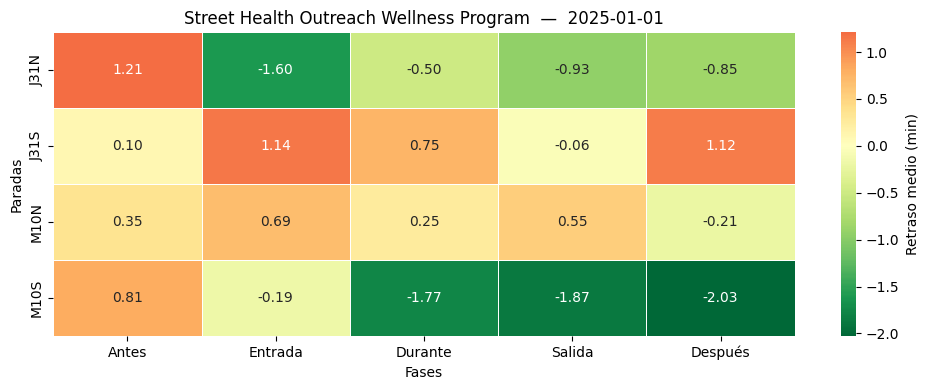

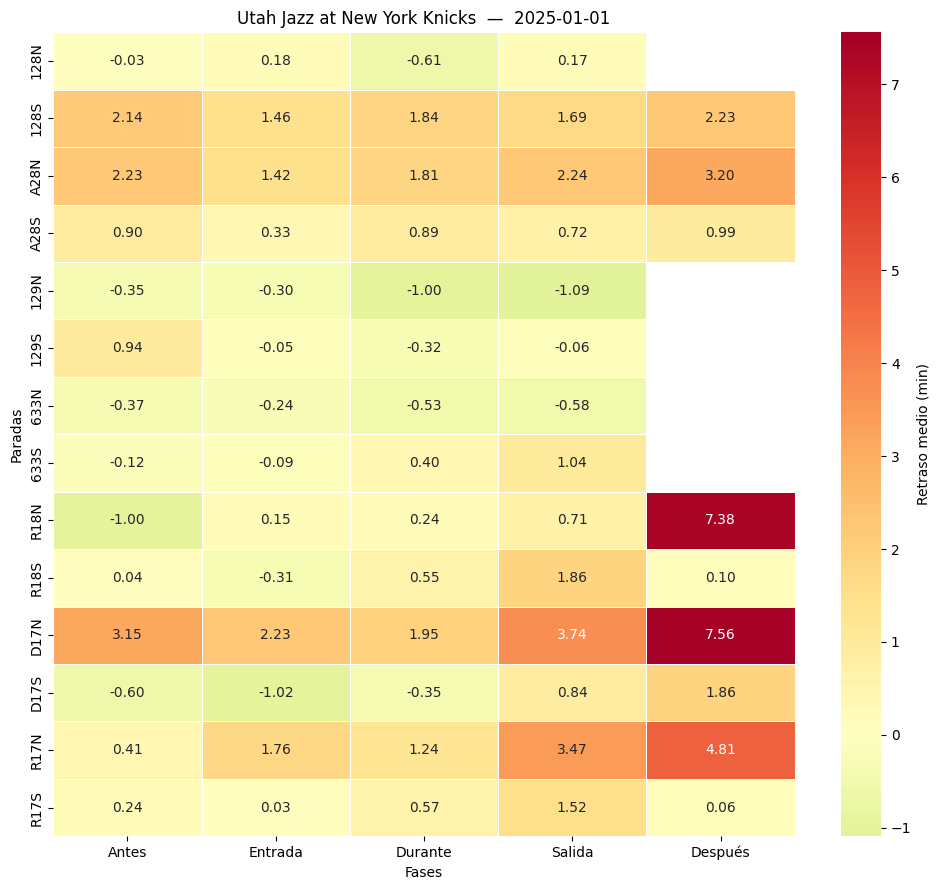

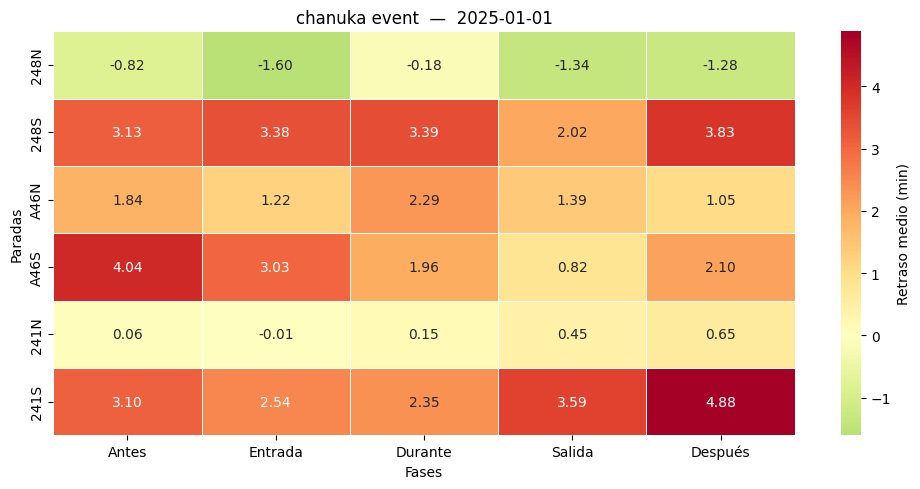

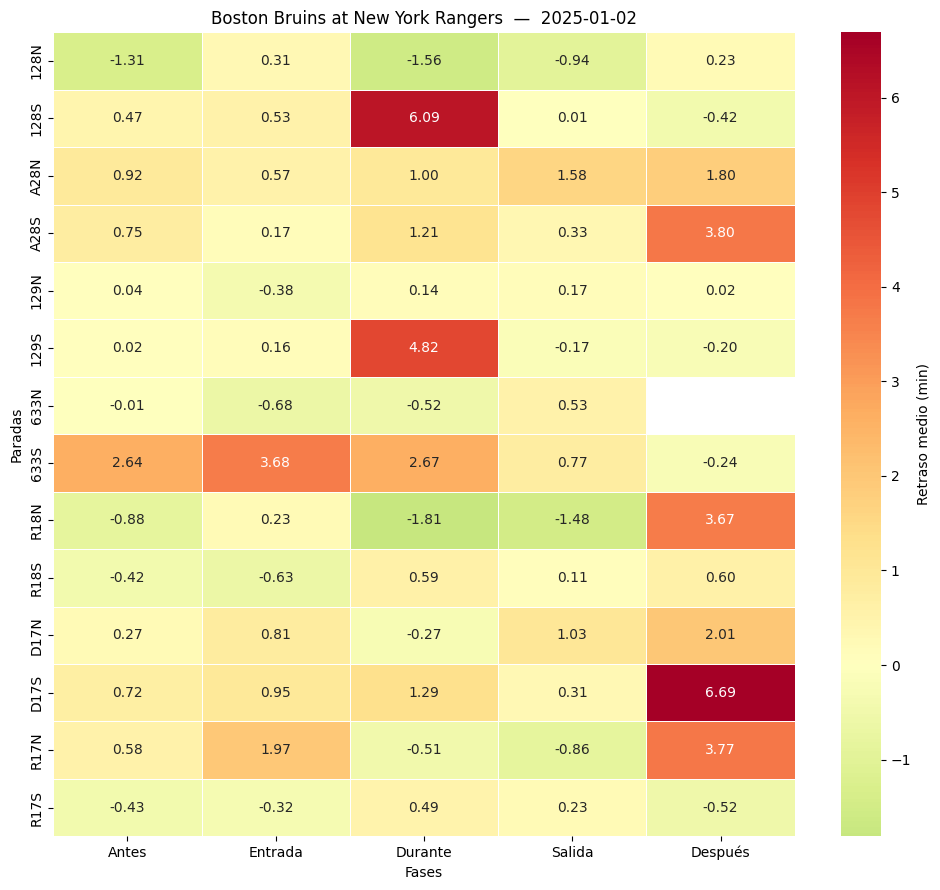

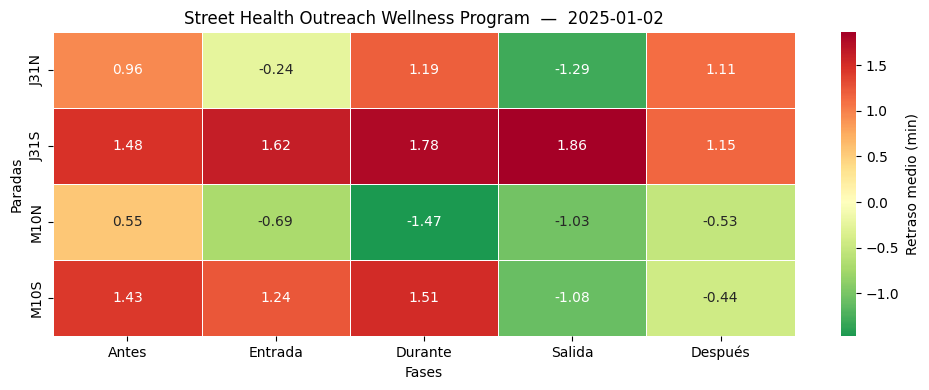

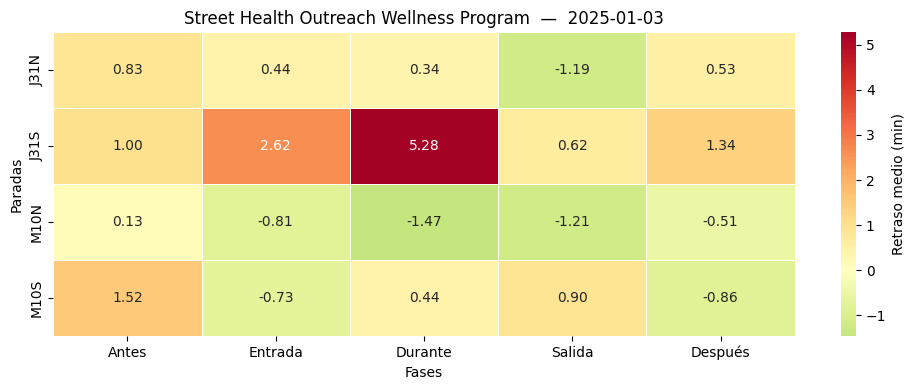

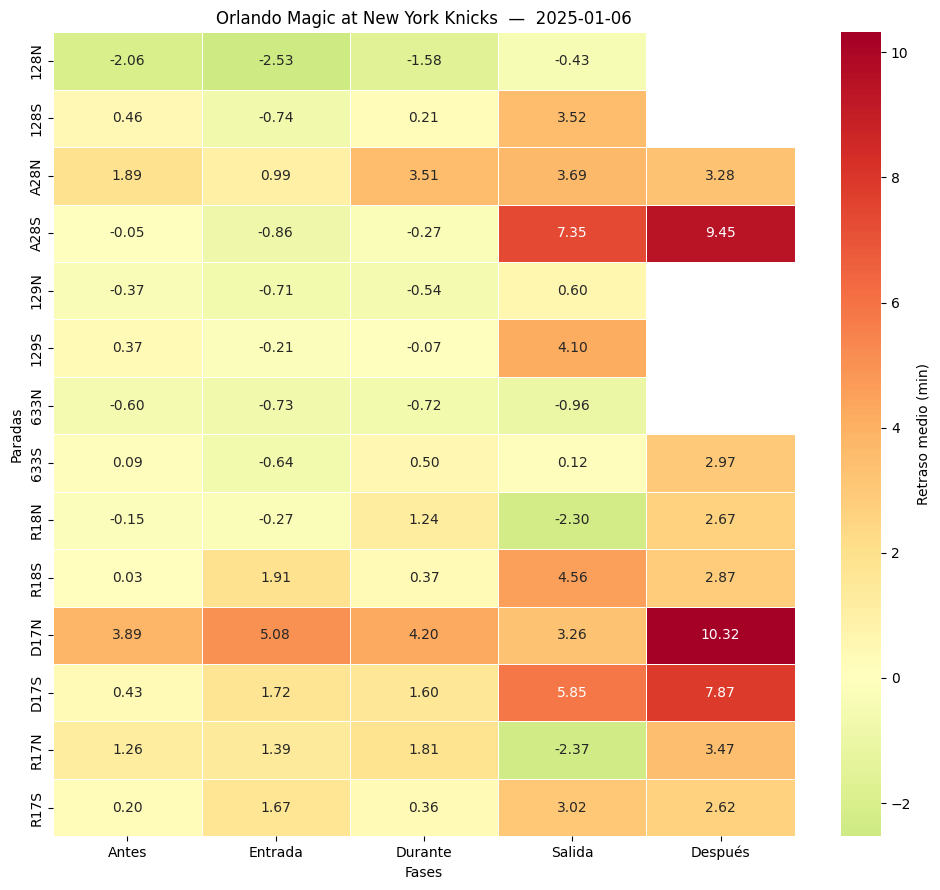

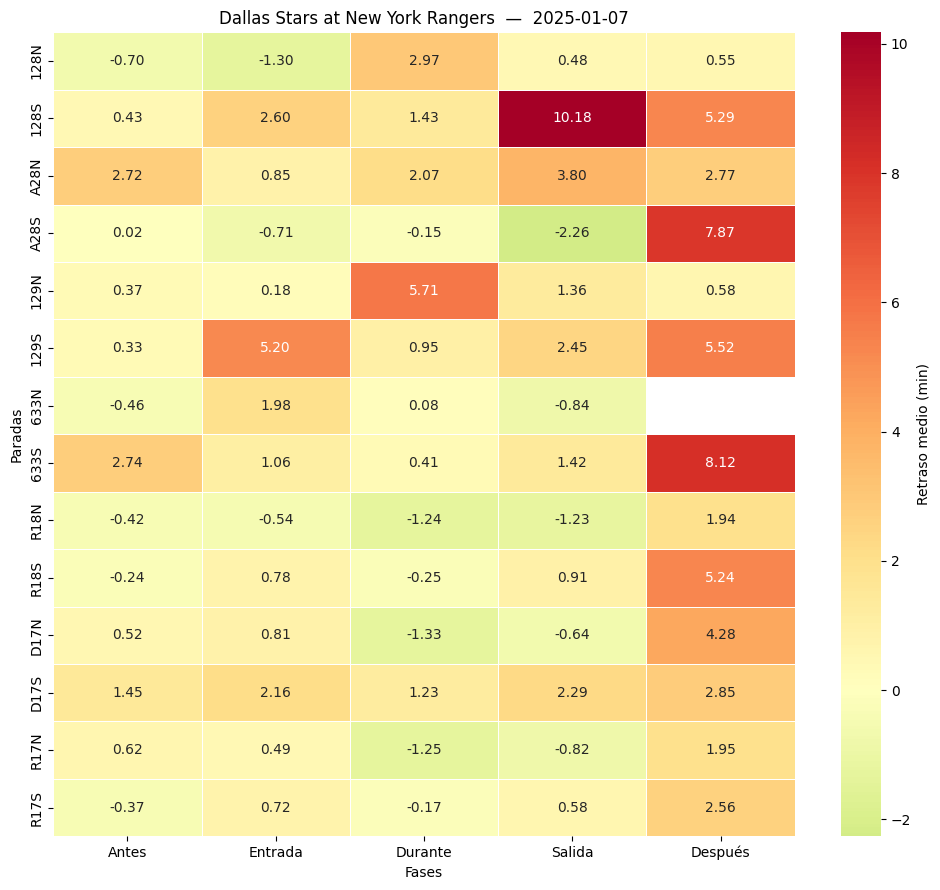

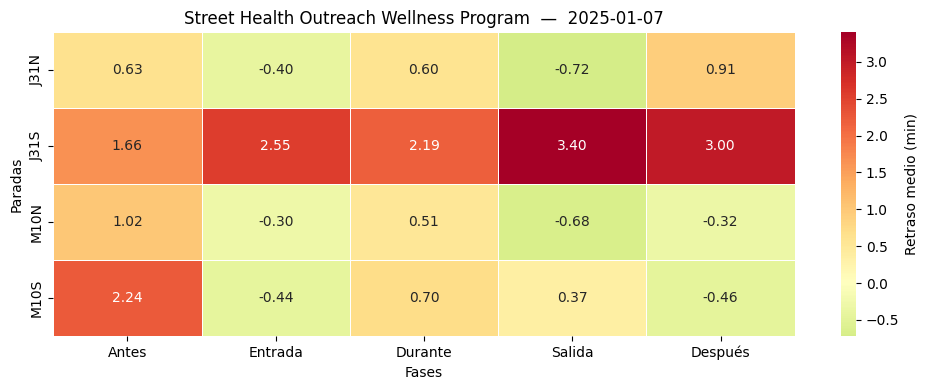

In [100]:
fases = ['Antes', 'Entrada', 'Durante', 'Salida', 'Después']

for (fecha, evento_nombre), grupo in df_resumen.groupby(['Fecha', 'Evento']):
    df_plot = grupo.set_index('Parada')[fases]

    plt.figure(figsize=(10, len(df_plot) * 0.5 + 2))
    sns.heatmap(
        df_plot, annot=True, fmt='.2f', cmap='RdYlGn_r',
        center=0, linewidths=0.5, cbar_kws={'label': 'Retraso medio (min)'}
    )
    plt.title(f'{evento_nombre}  —  {fecha}')
    plt.xlabel('Fases')
    plt.ylabel('Paradas')
    plt.tight_layout()
    plt.show()


## 3.3 Análisis simplificado (3 fases)

Versión condensada que agrupa el evento en tres bloques más amplios con ventana de 1.5 horas:
- **Antes**: referencia de retraso previo al evento.
- **Evento**: toda la duración del evento con margen de entrada/salida.
- **Después**: retraso residual post-evento.

Útil para una visión rápida de si el evento genera un pico y si el sistema se recupera.

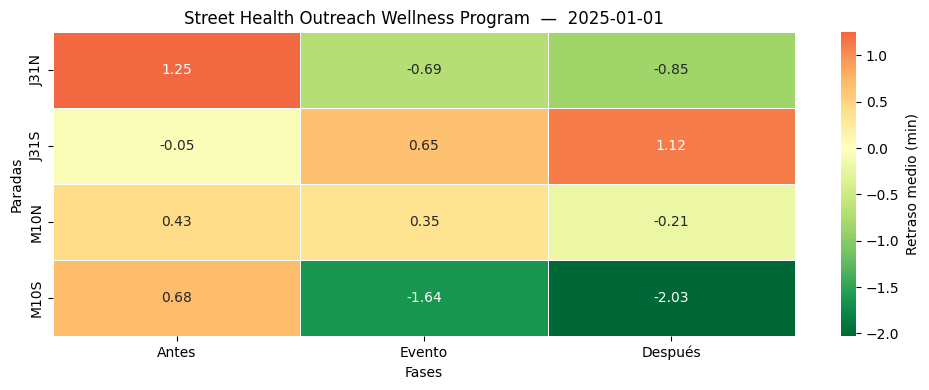

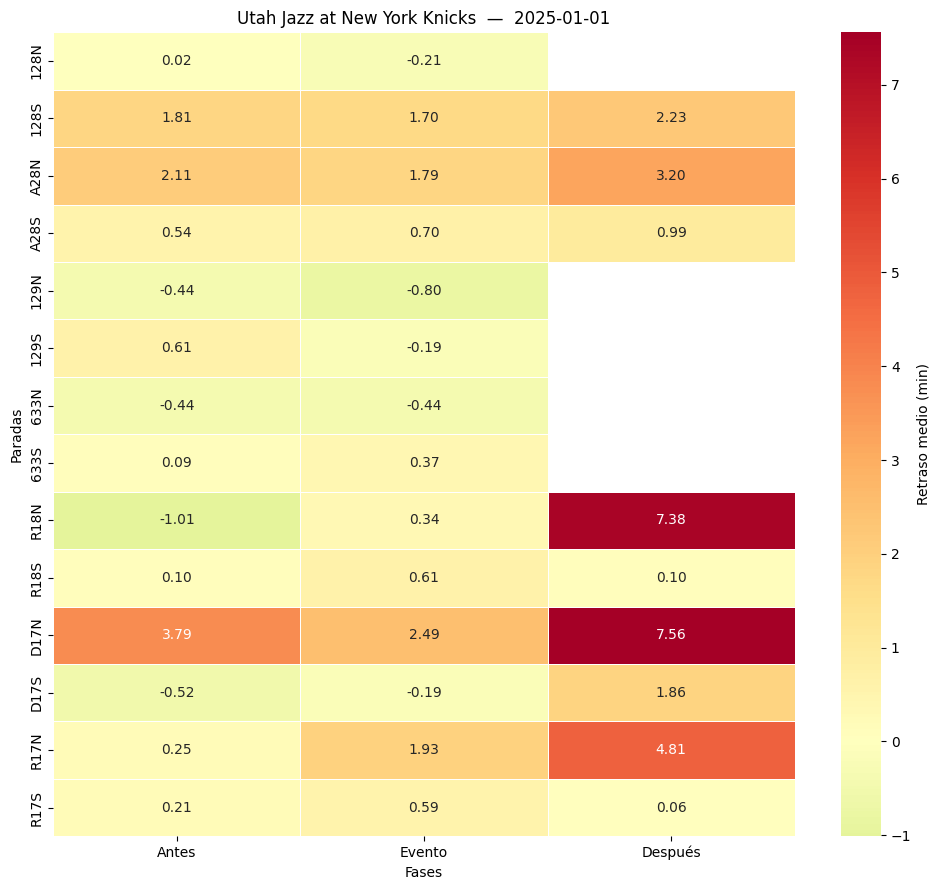

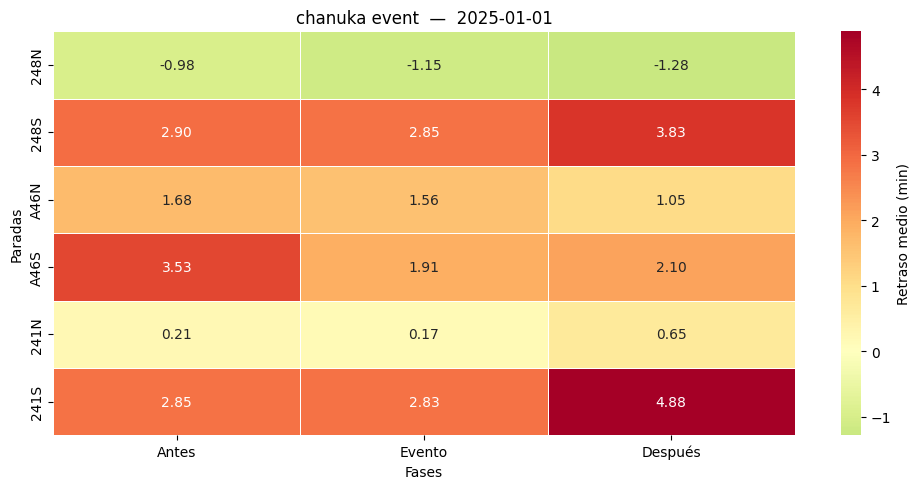

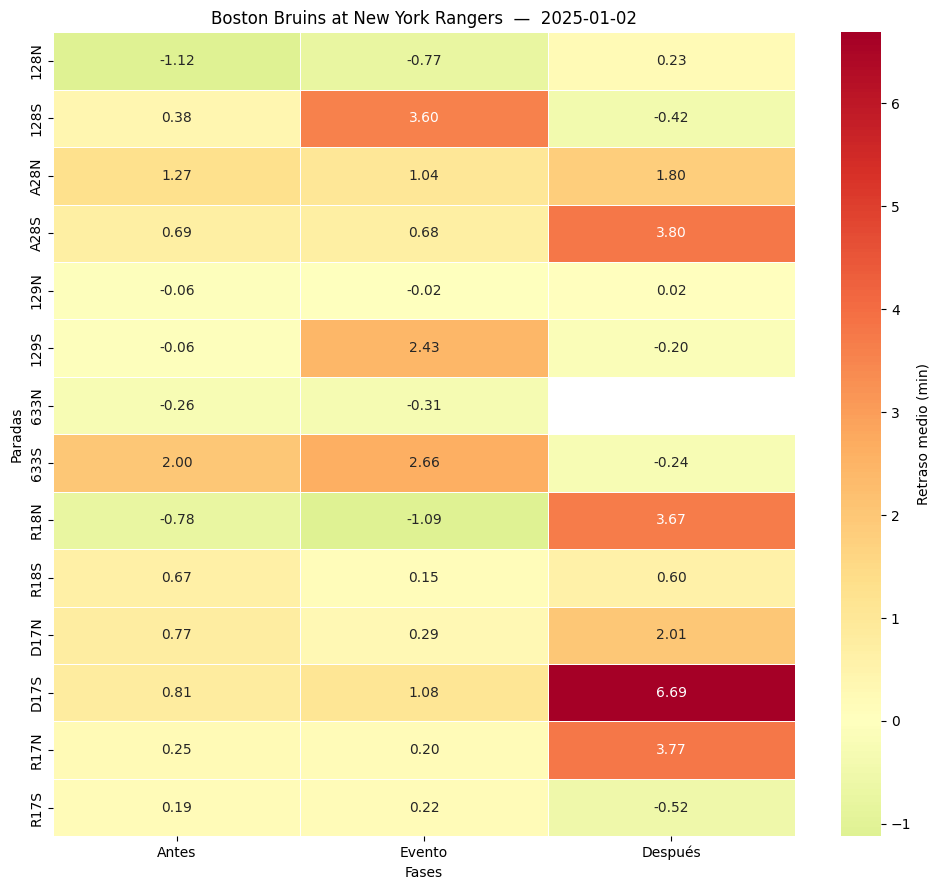

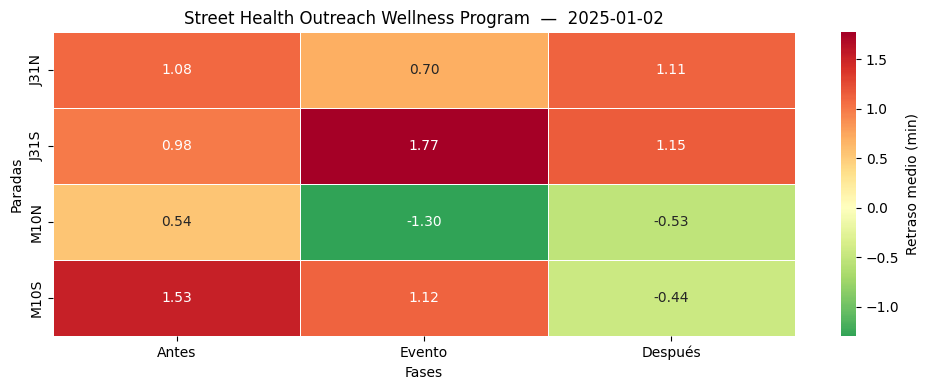

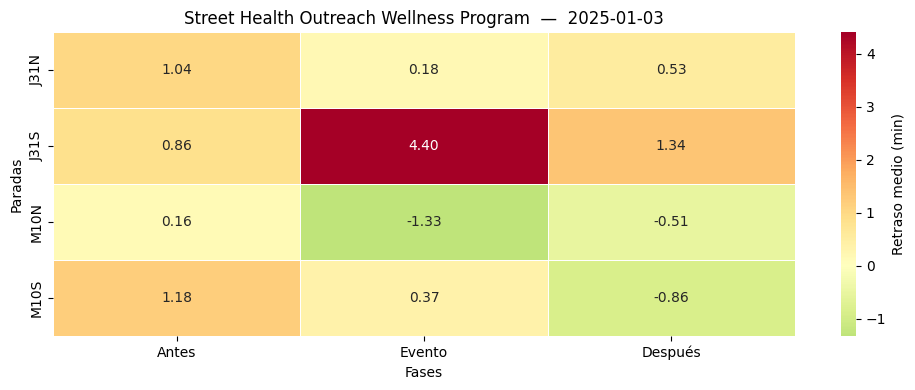

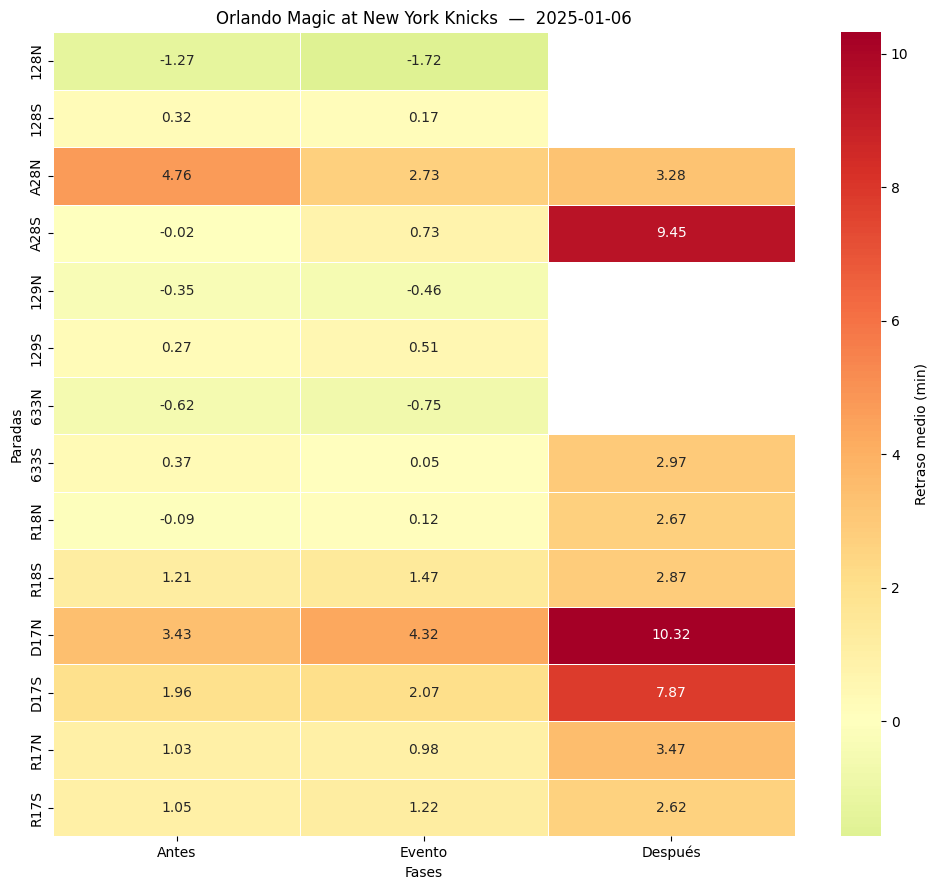

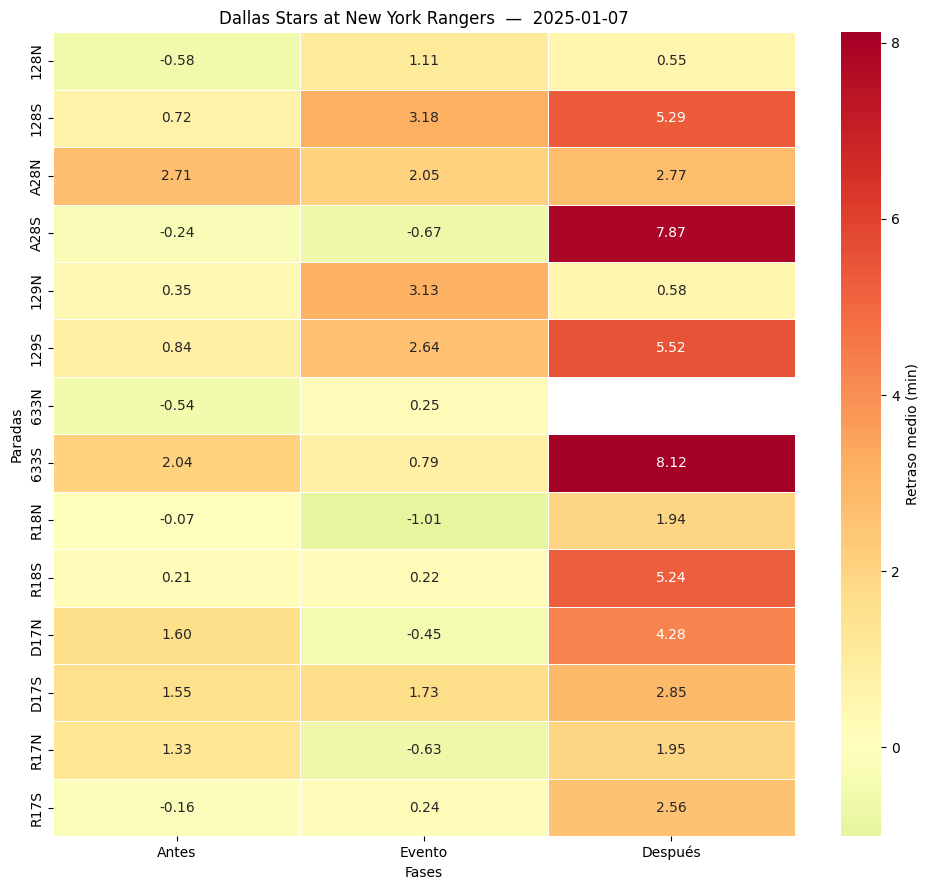

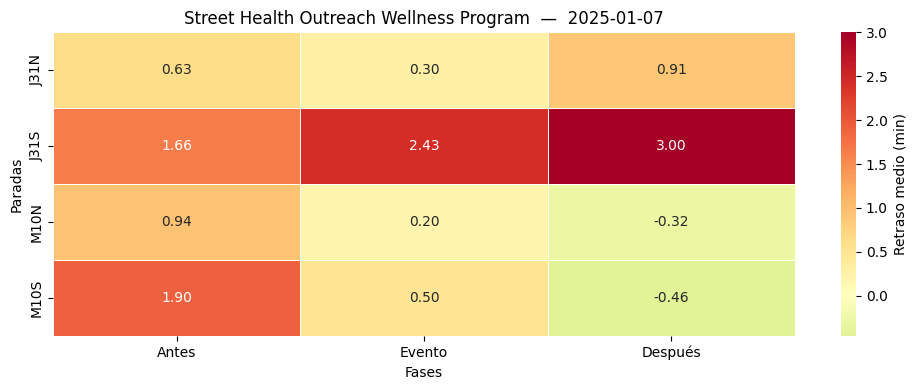

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

resumen_final_3 = []

ventana_antes  = pd.Timedelta(hours=2)
ventana_evento = pd.Timedelta(hours=1.5)

for _, fila in df_e.iterrows():
    evento_nombre = fila["nombre_evento"]
    stop          = fila["stop_id"]
    fecha         = fila["fecha_inicio"]
    hora_inicio   = pd.to_timedelta(fila["hora_inicio"])
    hora_salida   = pd.to_timedelta(fila["hora_salida_estimada"])

    df_dia    = df_s[df_s["service_date"] == fecha]
    df_parada = df_dia[df_dia["stop_id"] == stop]

    antes = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_antes*4) &
        (df_parada["td_real"] <  hora_inicio - ventana_evento)
    ]
    evento_ext = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_evento) &
        (df_parada["td_real"] <= hora_salida + ventana_evento)
    ]
    despues = df_parada[df_parada["td_real"] > hora_salida + ventana_evento]

    resumen_final_3.append({
        "Fecha":         fecha,
        "Evento_nombre": evento_nombre,
        "Parada":        stop,
        "Antes":         round(antes["delay_minutes"].mean(),      2),
        "Evento":        round(evento_ext["delay_minutes"].mean(), 2),
        "Después":       round(despues["delay_minutes"].mean(),    2),
    })

df_resumen_3fases_nuevo = pd.DataFrame(resumen_final_3)
fases_plot = ["Antes", "Evento", "Después"]

for (fecha, evento_nombre), grupo in df_resumen_3fases_nuevo.groupby(["Fecha", "Evento_nombre"]):
    df_plot = grupo.set_index("Parada")[fases_plot]

    plt.figure(figsize=(10, len(df_plot)*0.5 + 2))
    sns.heatmap(
        df_plot, annot=True, fmt=".2f", cmap="RdYlGn_r",
        center=0, linewidths=0.5, cbar_kws={"label": "Retraso medio (min)"}
    )
    plt.title(f'{evento_nombre}  —  {fecha}')
    plt.xlabel("Fases"); plt.ylabel("Paradas")
    plt.tight_layout()
    plt.show()


## 3.4 Trenes unscheduled — antes / durante / después

Cuenta los **trenes extra** (`trip_uid` únicos) desplegados por la MTA en las paradas del evento en 3 franjas de 1.5 horas:
- **Antes**: de −3h a −1.5h respecto al inicio.
- **Durante**: de −1.5h antes del inicio a +1.5h después del fin.
- **Después**: de +1.5h a +3h tras el fin.

Un aumento de trenes unscheduled **durante** indica refuerzo activo del servicio; un aumento **antes** sugiere preparación anticipada.

,fecha_inicio,Evento,Antes,Durante,Después
0,2025-01-01,Street Health Outreach Wellness Program,0,4,0
1,2025-01-01,Utah Jazz at New York Knicks,11,57,12
2,2025-01-01,chanuka event,1,1,1
3,2025-01-02,Boston Bruins at New York Rangers,40,163,23
4,2025-01-02,Street Health Outreach Wellness Program,1,14,0
5,2025-01-03,Street Health Outreach Wellness Program,2,19,0
6,2025-01-06,Orlando Magic at New York Knicks,65,195,16
7,2025-01-07,Dallas Stars at New York Rangers,91,237,39
8,2025-01-07,Street Health Outreach Wellness Program,0,13,0


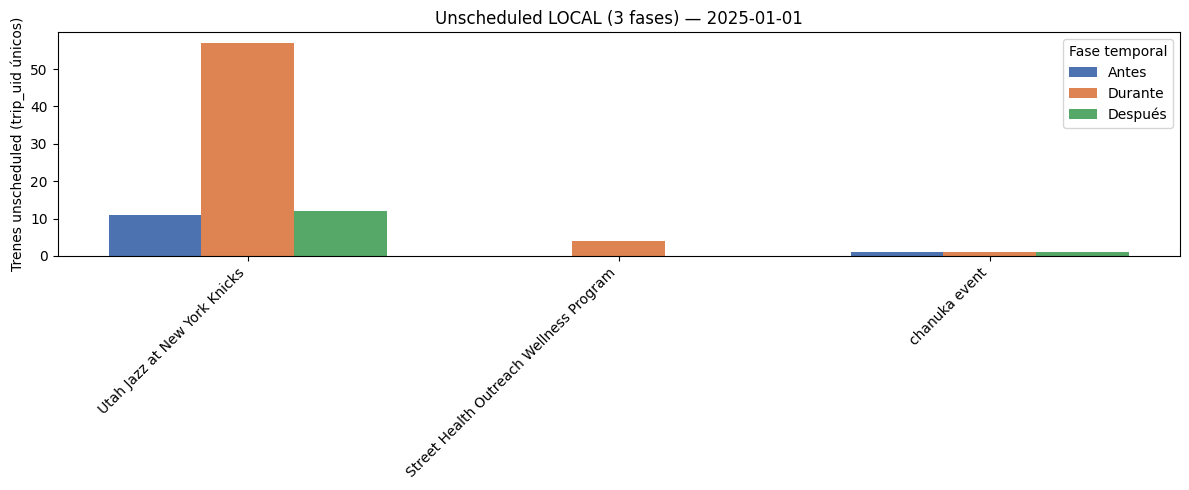

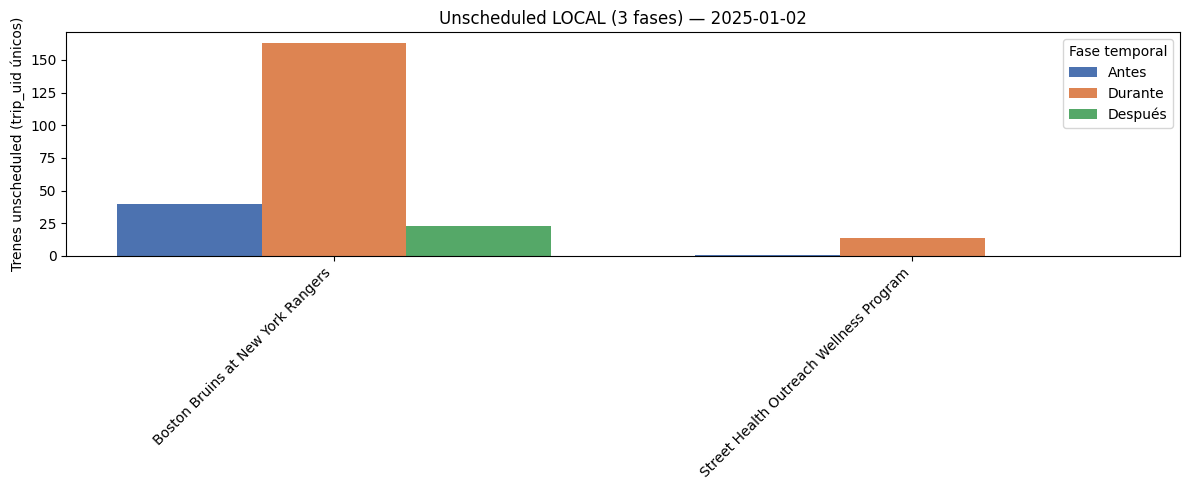

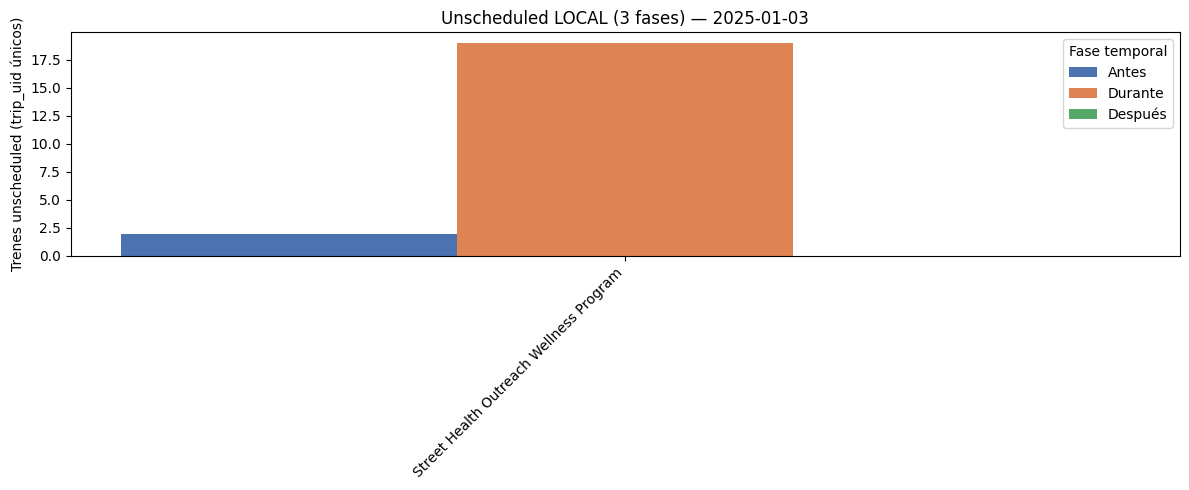

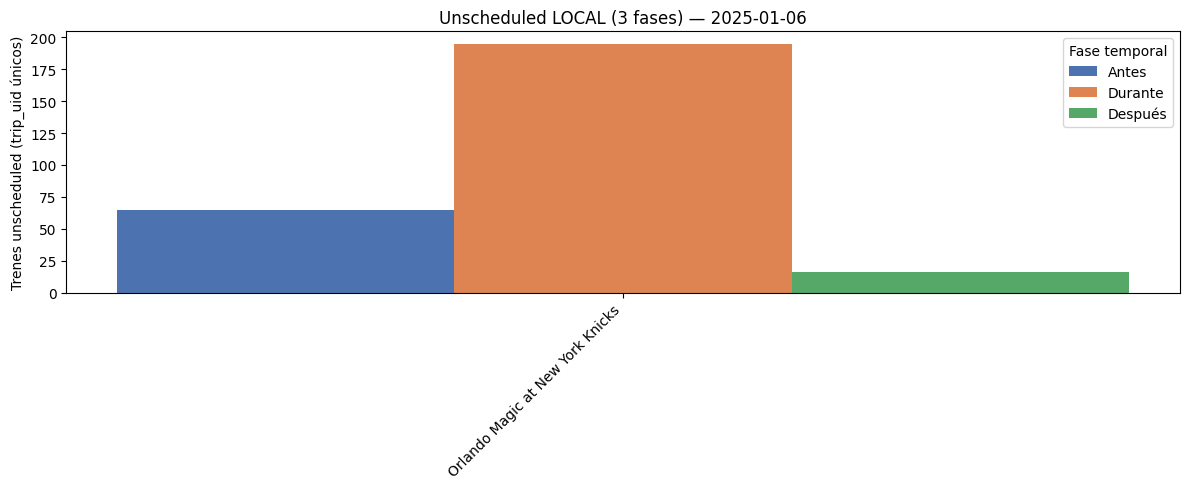

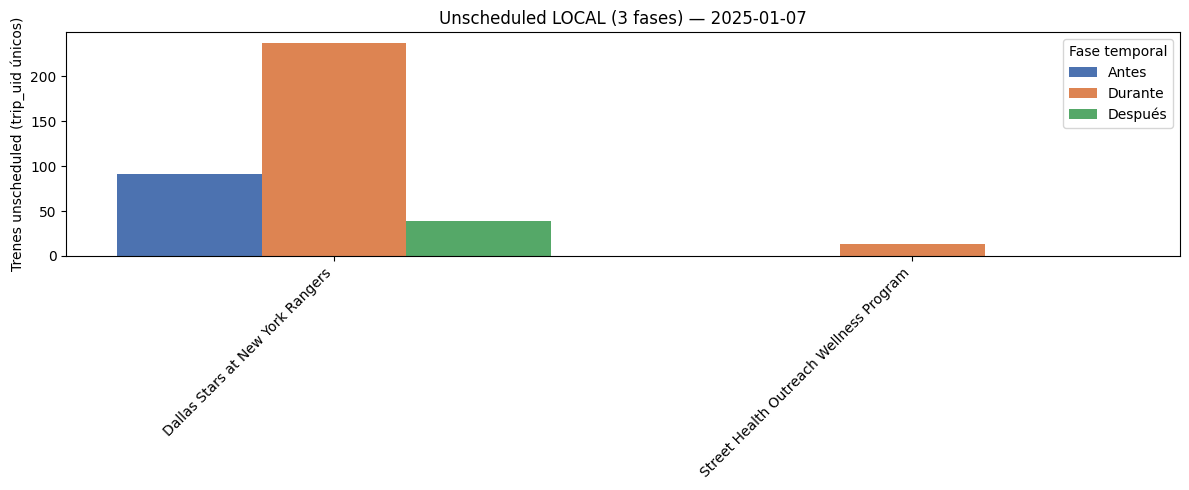

In [102]:
import matplotlib.pyplot as plt

ventana_uns = pd.Timedelta(hours=1.5)

eventos_uns = (
    df_e.groupby(["fecha_inicio", "nombre_evento"], as_index=False)
    .agg(
        hora_inicio=("hora_inicio", "first"),
        hora_salida_estimada=("hora_salida_estimada", "first"),
    )
)

def calcular_3_barras_local():
    rows = []
    for _, ev in eventos_uns.iterrows():
        fecha   = ev["fecha_inicio"]
        evento  = ev["nombre_evento"]
        inicio  = pd.to_timedelta(ev["hora_inicio"])
        salida  = pd.to_timedelta(ev["hora_salida_estimada"])
        
        stops_evento = (
            df_e[(df_e["fecha_inicio"] == fecha) & (df_e["nombre_evento"] == evento)]
            ["stop_id"].dropna().unique().tolist()
        )
        
        df_dia = df_u[(df_u["service_date"] == fecha) & (df_u["stop_id"].isin(stops_evento))]
        
        antes   = df_dia[(df_dia["td_real"] >= inicio - 2*ventana_uns) & (df_dia["td_real"] < inicio - ventana_uns)]
        durante = df_dia[(df_dia["td_real"] >= inicio - ventana_uns)   & (df_dia["td_real"] <= salida + ventana_uns)]
        despues = df_dia[(df_dia["td_real"] >  salida + ventana_uns)   & (df_dia["td_real"] <= salida + 2*ventana_uns)]
        
        rows.append({
            "fecha_inicio": fecha, "Evento": evento,
            "Antes":   antes["trip_uid"].nunique(),
            "Durante": durante["trip_uid"].nunique(),
            "Después": despues["trip_uid"].nunique(),
        })
    return pd.DataFrame(rows)

def plot_3_barras(df, titulo, orden_eventos):
    colores = {"Antes": "#4C72B0", "Durante": "#DD8452", "Después": "#55A868"}
    for fecha, sub in df.groupby("fecha_inicio"):
        orden = orden_eventos.get(fecha, sub["Evento"].tolist())
        sub   = sub.set_index("Evento").reindex(orden).reset_index()
        x     = range(len(sub))
        width = 0.25
        plt.figure(figsize=(12, 5))
        plt.bar([i-width for i in x], sub["Antes"],   width, color=colores["Antes"],   label="Antes")
        plt.bar(x,                    sub["Durante"],  width, color=colores["Durante"], label="Durante")
        plt.bar([i+width for i in x], sub["Después"], width, color=colores["Después"], label="Después")
        plt.xticks(list(x), sub["Evento"], rotation=45, ha="right")
        plt.ylabel("Trenes unscheduled (trip_uid únicos)")
        plt.title(f"{titulo} — {fecha}")
        plt.legend(title="Fase temporal")
        plt.tight_layout()
        plt.show()

df_local_3 = calcular_3_barras_local()
display(df_local_3)

orden_eventos = (
    df_local_3.sort_values(["fecha_inicio", "Durante"], ascending=[True, False])
    .groupby("fecha_inicio")["Evento"].apply(list).to_dict()
)

plot_3_barras(df_local_3, "Unscheduled LOCAL (3 fases)", orden_eventos)

## 3.5 Trenes unscheduled — 5 fases

Versión detallada con 5 fases de 1.5 horas cada una, equivalente a la sección 3.2 pero para trenes no planificados:

| Fase | Ventana |
|------|---------|
| Antes | de −6h a −3h antes del inicio |
| Entrada | de −3h a −1.5h |
| Durante | de −1.5h a +1.5h del fin |
| Salida | de +1.5h a +3h del fin |
| Después | de +3h a +6h del fin |

Permite ver si el refuerzo de servicio se adelanta a la llegada de asistentes y cuánto tarda en retirarse.

,fecha_inicio,Evento,Antes,Entrada,Durante,Salida,Después
0,2025-01-01,Street Health Outreach Wellness Program,0,0,4,0,0
1,2025-01-01,Utah Jazz at New York Knicks,23,11,57,12,0
2,2025-01-01,chanuka event,9,1,1,1,8
3,2025-01-02,Boston Bruins at New York Rangers,74,40,163,23,0
4,2025-01-02,Street Health Outreach Wellness Program,1,1,14,0,0
5,2025-01-03,Street Health Outreach Wellness Program,0,2,19,0,0
6,2025-01-06,Orlando Magic at New York Knicks,112,65,195,16,0
7,2025-01-07,Dallas Stars at New York Rangers,111,91,237,39,0
8,2025-01-07,Street Health Outreach Wellness Program,11,0,13,0,0


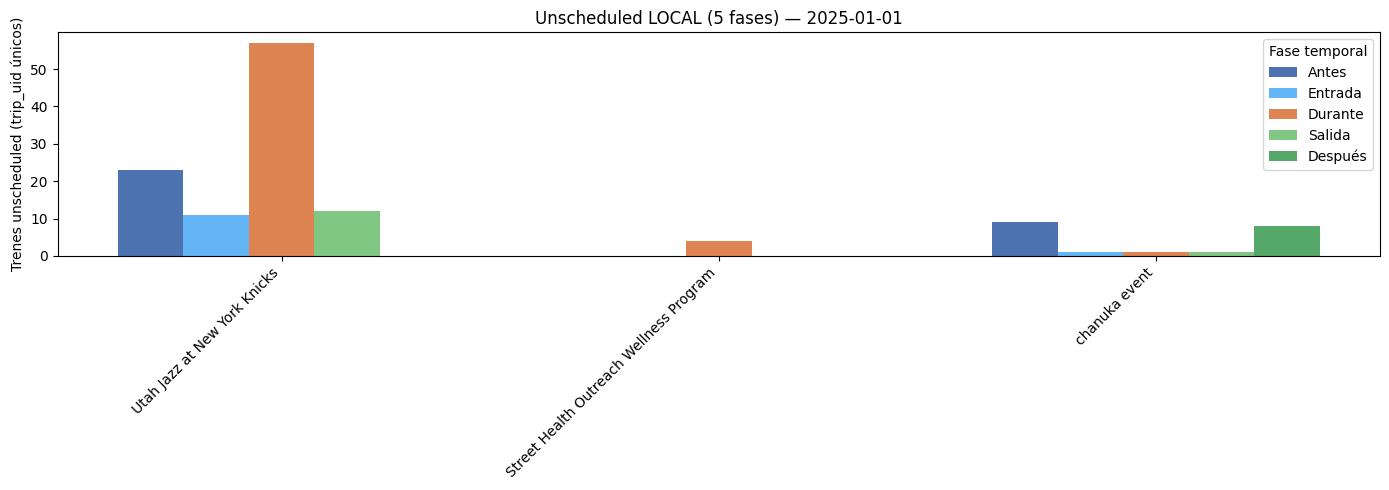

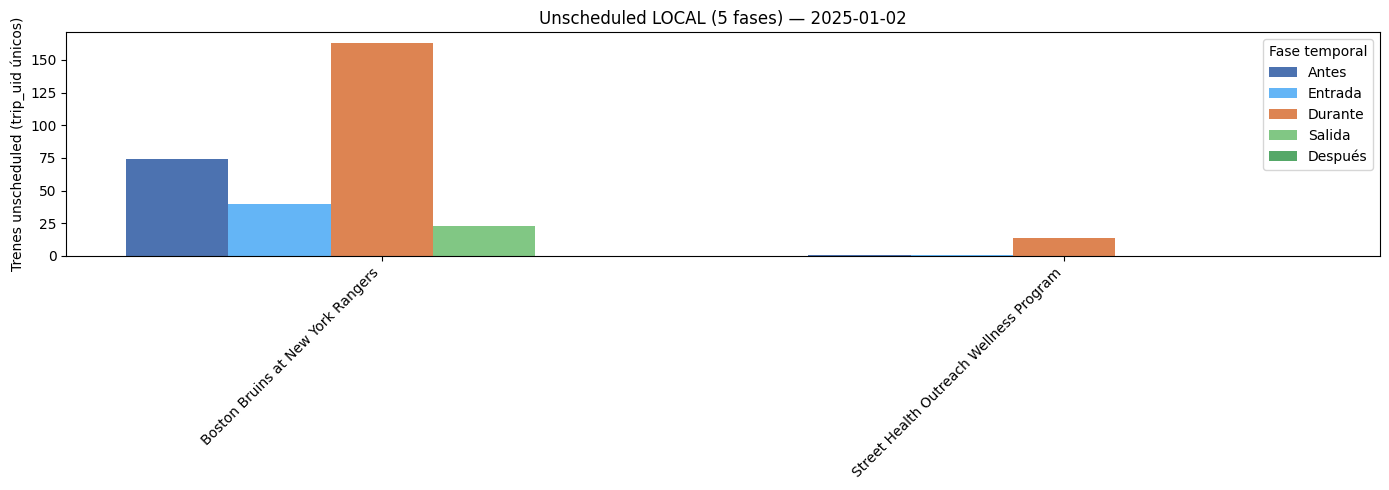

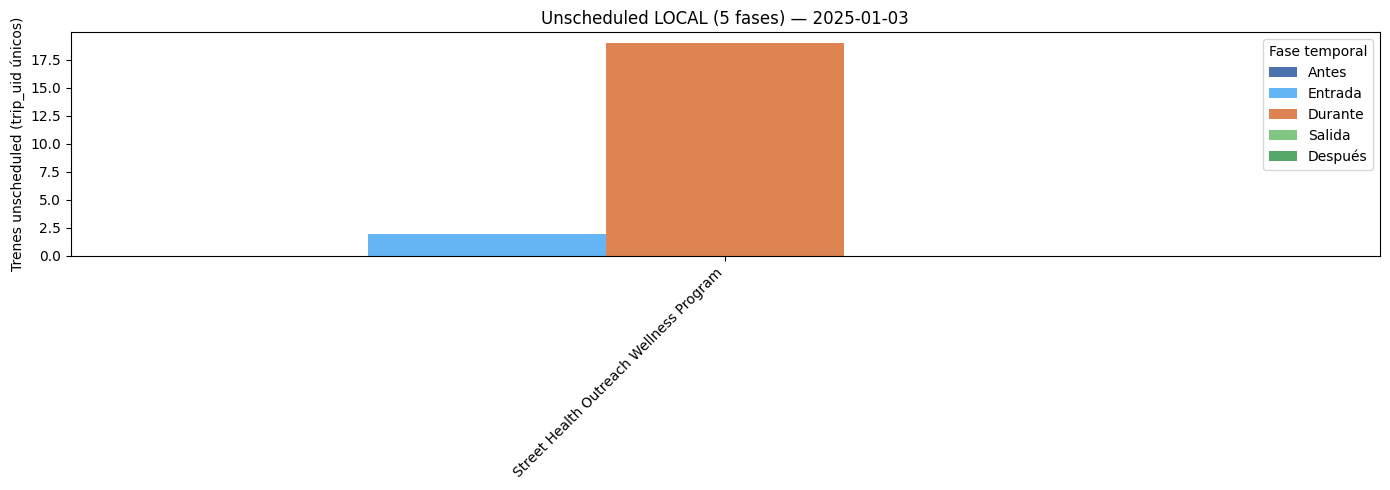

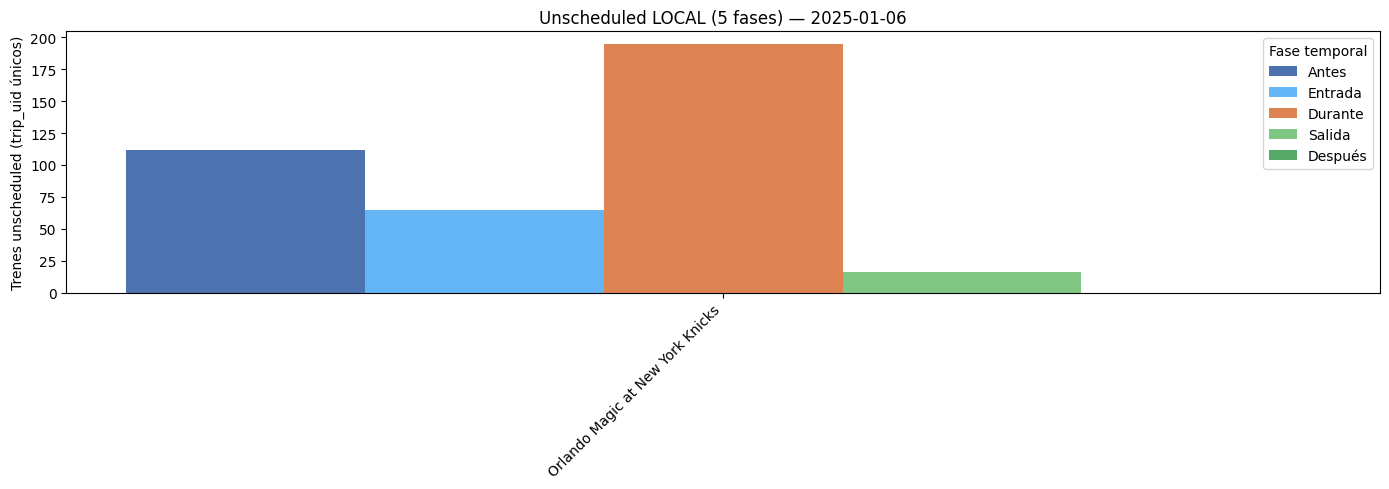

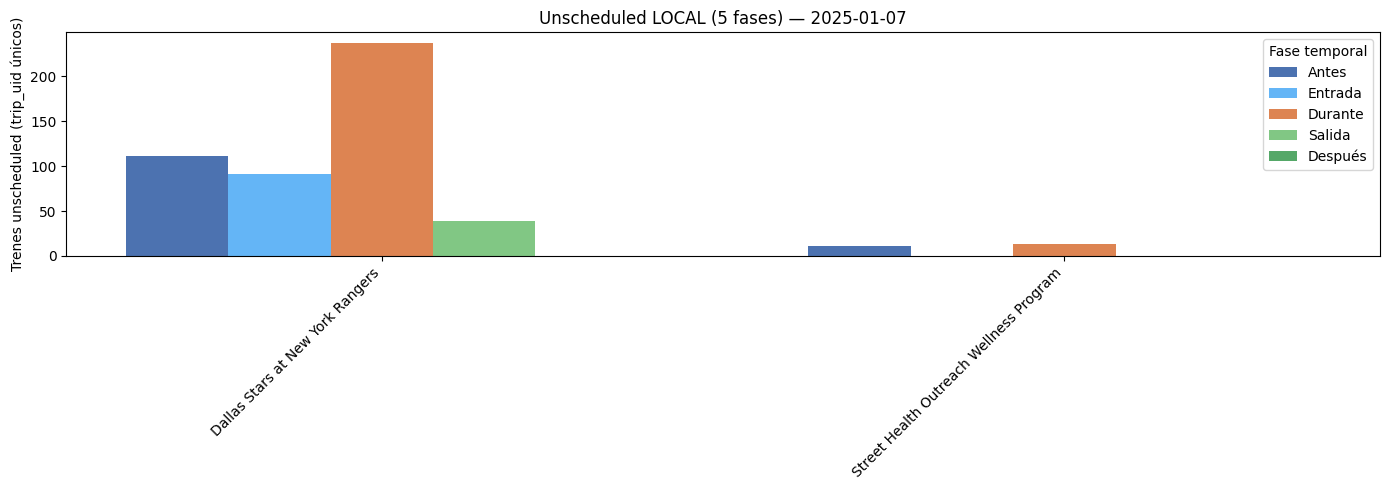

In [103]:
def calcular_5_barras_local():
    rows = []
    for _, ev in eventos_uns.iterrows():
        fecha   = ev["fecha_inicio"]
        evento  = ev["nombre_evento"]
        inicio  = pd.to_timedelta(ev["hora_inicio"])
        salida  = pd.to_timedelta(ev["hora_salida_estimada"])
        
        stops_evento = (
            df_e[(df_e["fecha_inicio"] == fecha) & (df_e["nombre_evento"] == evento)]
            ["stop_id"].dropna().unique().tolist()
        )
        
        df_dia = df_u[(df_u["service_date"] == fecha) & (df_u["stop_id"].isin(stops_evento))]
        
        antes   = df_dia[(df_dia["td_real"] >= inicio - 4*ventana_uns) & (df_dia["td_real"] < inicio - 2*ventana_uns)]
        entrada = df_dia[(df_dia["td_real"] >= inicio - 2*ventana_uns) & (df_dia["td_real"] < inicio - ventana_uns)]
        durante = df_dia[(df_dia["td_real"] >= inicio - ventana_uns)   & (df_dia["td_real"] <= salida + ventana_uns)]
        salida_w= df_dia[(df_dia["td_real"] >  salida + ventana_uns)   & (df_dia["td_real"] <= salida + 2*ventana_uns)]
        despues = df_dia[(df_dia["td_real"] >  salida + 2*ventana_uns) & (df_dia["td_real"] <= salida + 4*ventana_uns)]
        
        rows.append({
            "fecha_inicio": fecha, "Evento": evento,
            "Antes":   antes["trip_uid"].nunique(),
            "Entrada": entrada["trip_uid"].nunique(),
            "Durante": durante["trip_uid"].nunique(),
            "Salida":  salida_w["trip_uid"].nunique(),
            "Después": despues["trip_uid"].nunique(),
        })
    return pd.DataFrame(rows)

def plot_5_barras(df, titulo, orden_eventos):
    colores = {
        "Antes":   "#4C72B0",
        "Entrada": "#64B5F6",
        "Durante": "#DD8452",
        "Salida":  "#81C784",
        "Después": "#55A868",
    }
    for fecha, sub in df.groupby("fecha_inicio"):
        orden = orden_eventos.get(fecha, sub["Evento"].tolist())
        sub   = sub.set_index("Evento").reindex(orden).reset_index()
        x     = range(len(sub))
        width = 0.15
        plt.figure(figsize=(14, 5))
        offsets = [-2, -1, 0, 1, 2]
        for fase, offset in zip(["Antes", "Entrada", "Durante", "Salida", "Después"], offsets):
            plt.bar([i + offset*width for i in x], sub[fase], width, color=colores[fase], label=fase)
        plt.xticks(list(x), sub["Evento"], rotation=45, ha="right")
        plt.ylabel("Trenes unscheduled (trip_uid únicos)")
        plt.title(f"{titulo} — {fecha}")
        plt.legend(title="Fase temporal")
        plt.tight_layout()
        plt.show()

df_local_5 = calcular_5_barras_local()
display(df_local_5)

orden_eventos = (
    df_local_5.sort_values(["fecha_inicio", "Durante"], ascending=[True, False])
    .groupby("fecha_inicio")["Evento"].apply(list).to_dict()
)

plot_5_barras(df_local_5, "Unscheduled LOCAL (5 fases)", orden_eventos)